In [33]:
import numpy as np
import random
import gym
#from gym.wrappers import Monitor
import glob
import io

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

In [57]:

env = gym.make("Taxi-v3")
env.reset()

#Current State
print(env.s)

# Primitive Actions
action = ["south", "north", "east", "west","pickup","dropoff","option_B","option_Y","option_R","option_G"]

#print ("Number of actions that an agent can take:", env.nA)

# Example Transitions

rnd_action = random.randint(0,5)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.s=next_state


54
Action taken: pickup
Transition probability: {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 0, 0], dtype=int8)}
Next state: 54
Reward recieved: -10
Terminal state: False


In [35]:
RGBY = [(0, 0), (0, 4), (4, 0), (4, 3)]
option_R= [[1,3,0,0,0], [1,3,0,0,0],[1,3,3,3,3],[1,1,3,1,3],[1,1,3,1,3]]
option_B= [[2,0,2,0,3], [2,0,2,0,3],[2,2,2,0,3],[1,2,1,0,3],[1,2,1,0,3]]
option_Y= [[0,3,0,0,0], [0,3,0,0,0],[0,3,3,3,3],[0,1,3,1,3],[0,1,3,1,3]]
option_G= [[2,0,2,2,2], [2,0,2,2,1],[2,2,2,2,1],[1,1,1,1,1],[1,1,1,1,1]]
R = [0, 0]
G=[0, 4]
Y=[4, 0]
B=[4, 3]

In [36]:

def ReachB(state):
    taxirow, taxicol, passidx, destidx = stateData(state)

    optdone=False
    reachedGoal=False
    if(taxirow==4 and taxicol==3):
        optdone=True
        if(passidx==3):
            optact=4 #pick up
        elif(destidx==3 and passidx==4):
            optact=5 #drop off
            reachedGoal=True
        else:
            optact=option_B[taxirow][taxicol]
    else:
        optact= option_B[taxirow][taxicol]

    return [optact,optdone,reachedGoal]

def ReachG(state):
    taxirow, taxicol, passidx, destidx = stateData(state)
    optdone=False
    reachedGoal=False
    if(taxirow==0 and taxicol==4):

        if(passidx==1):
            optact=4 #pick up
        elif(destidx==1 and passidx==4):
            optact=5 #drop off
            reachedGoal=True
        else:
            optact=option_G[taxirow][taxicol]
        optdone=True
    else:
        optact= option_G[taxirow][taxicol]

    return [optact,optdone,reachedGoal]


def ReachR(state):
    taxirow, taxicol, passidx, destidx = stateData(state)
    optdone=False
    reachedGoal=False
    if(taxirow==0 and taxicol==0):
        if(passidx==0):
            optact=4 #pick up
        elif(destidx==0 and passidx==4):
            optact=5 #drop off
            reachedGoal=True
        else:
            optact=option_R[taxirow][taxicol]
        optdone=True

    else:
        optact= option_R[taxirow][taxicol]

    return [optact,optdone,reachedGoal]


def ReachY(state):
    taxirow, taxicol, passidx, destidx = stateData(state)
    optdone=False
    reachedGoal=False
    if(taxirow==4 and taxicol==0):
        optdone=True
        if(passidx==2):
            optact=4 #pick up
        elif(destidx==2 and passidx==4):
            optact=5 #drop off
            reachedGoal=True
        else:
            optact=option_Y[taxirow][taxicol]

    else:
        optact= option_Y[taxirow][taxicol]

    return [optact,optdone,reachedGoal]

def stateData(state):
  picdrop = state%20
  pos = state//20
  y = pos//5
  x = pos%5
  drop = picdrop%4
  passenger = picdrop//4
  return y,x,passenger,drop

In [37]:
# actions=[0,1,2,3,4,5,6,7,8,9]


SMDP

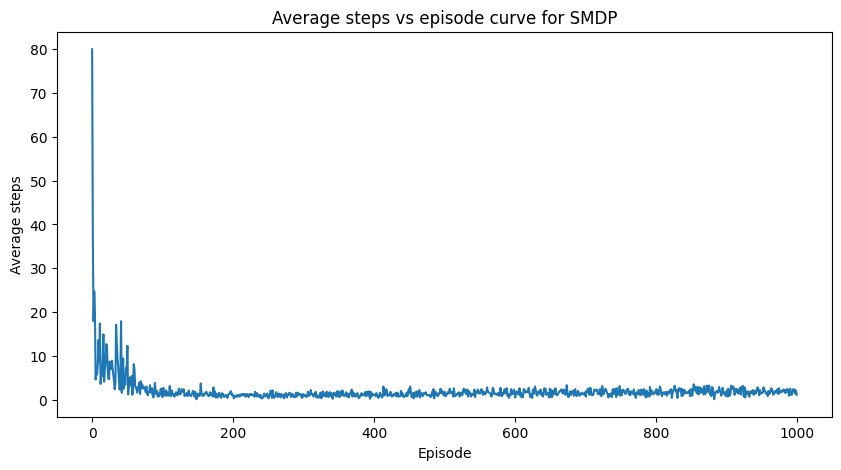

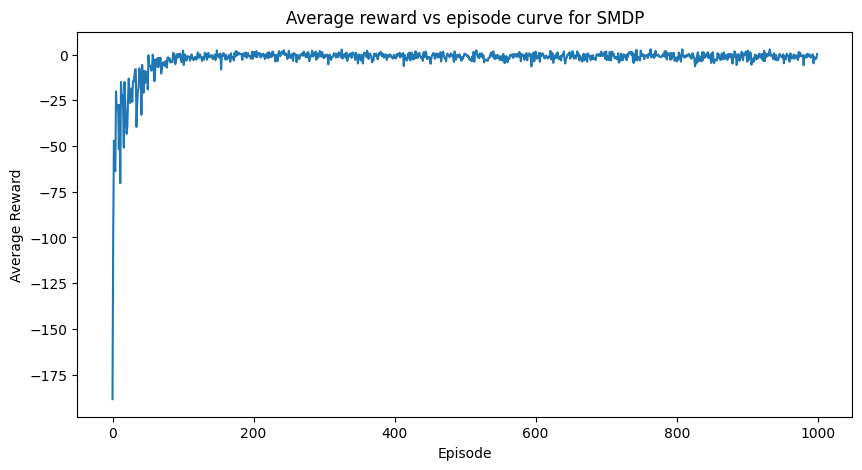

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from matplotlib import colors
def plot_Qstep(stepsVisitCount, message = "Steps plot"):

    plt.figure(figsize=(5,5))
    plt.title(message)
    plt.pcolor(stepsVisitCount, edgecolors='k', linewidths=1)
    plt.colorbar()
    for (x, y),z  in np.ndenumerate(stepsVisitCount.T):
        plt.text(x+.5, y+.5, f"{z:}", va="top", ha="center")
    plt.show()

from scipy.special import softmax
import random
#Update_Frequency Data structure? Check TODO 4

seed=42
rg = np.random.RandomState(seed)
def egreedy_policy(q_values,state,epsilon):
    rnd=rg.rand()

    if  rnd< epsilon:
        return  rg.choice(q_values.shape[-1])
    else:
        return np.argmax(q_values[state])
def softmax_policy(q_values,state,temp=0.9):
    rnd=rg.rand()
    x=softmax(q_values[state]/temp)
    return np.argmax(x)

#### SMDP Q-Learning
#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))

action_l=[0,1,2,3,4,5,ReachR,ReachG,ReachY,ReachB]
q_values_SMDP = np.zeros((500,10))
state_visit_SMDP=np.zeros(500)
frequency_SMDP=np.zeros((500,10))
steps_ep_smdp =[]
rewards_smdp=[]
avg_rewards_smdp=[]
avg_steps_ep_smdp =[]
# Add parameters you might need here
gamma = 0.9
alpha=0.9

for eps in range(10000):
    state = env.reset()
    done = False
    ep=0
    episode_reward=0
    itr=0
    # While episode is not over

    while not done :

        # Choose action
        action = egreedy_policy(q_values_SMDP, state, epsilon=0.1)

        #epsilon= epsilon/4
        # Checking if primitive action
        if action < 6:
            ep+=1
            # Perform regular Q-Learning update for state-action pair
            state_next, reward, done,_=env.step(action)
            action_next = np.argmax(q_values_SMDP[state_next])
            q_values_SMDP[state,action] += alpha*(reward +\
                gamma*q_values_SMDP[state_next, action_next]\
                - q_values_SMDP[state, action])
            frequency_SMDP[state,action]+=1
            state_visit_SMDP[state]+=1
            state=state_next
            episode_reward+=reward
        # Checking if action chosen is an option
        reward_bar = 0
        if action >=6:

            optdone = False
            cnt=0
            oldstate=state
            while (optdone == False):

                # Think about what this function might do?


                optact,optdone,reachedGoal = action_l[action](state)



                next_state, reward, done,_ = env.step(optact)

                # Is this formulation right? What is this term?
                reward_bar = gamma**cnt *reward+reward_bar

                # Complete SMDP Q-Learning Update

                action_next = np.argmax(q_values_SMDP[next_state])


                if optdone:
                    q_values_SMDP[oldstate,action] += alpha*(reward_bar +(gamma**cnt)*q_values_SMDP[next_state, action_next]- q_values_SMDP[oldstate, action])
                    frequency_SMDP[oldstate,action]+=1
                    state_visit_SMDP[oldstate]+=1
                    episode_reward+=reward_bar
                cnt+=1
                state = next_state



    rewards_smdp.append(episode_reward)
    steps_ep_smdp.append(ep)
    if(eps%10==0) :
        avg_rewards_smdp.append(np.mean(rewards_smdp[-10:]))
        avg_steps_ep_smdp.append(np.mean(steps_ep_smdp[-10:]))

#Average Reward Curves
plt.figure(figsize=(10,5))
plt.xlabel('Episode')
plt.ylabel('Average steps')
plt.plot([i for i in range(len(avg_steps_ep_smdp))],avg_steps_ep_smdp )
plt.title("Average steps vs episode curve for SMDP")
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.plot([i for i in range(len(avg_rewards_smdp))],avg_rewards_smdp )
plt.title("Average reward vs episode curve for SMDP")
plt.show()

In [39]:
print(q_values_SMDP.shape)

(500, 10)


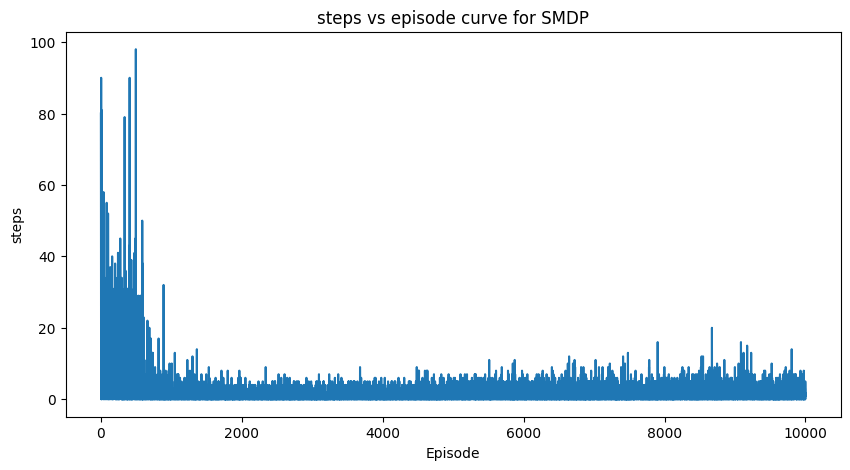

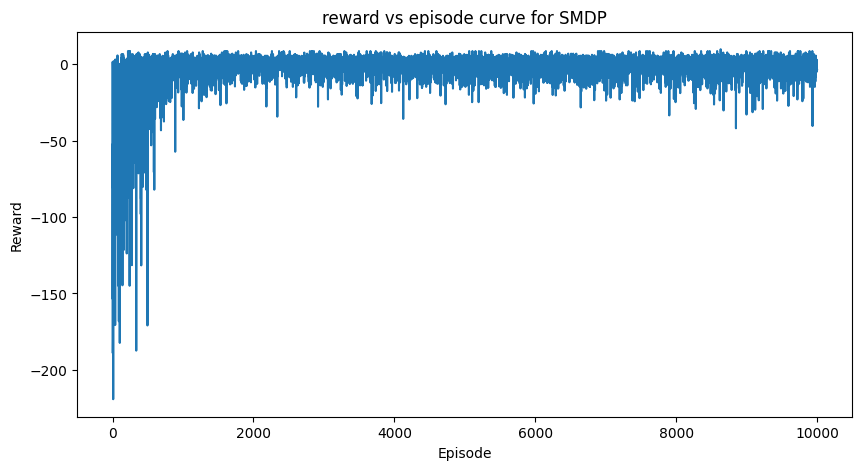

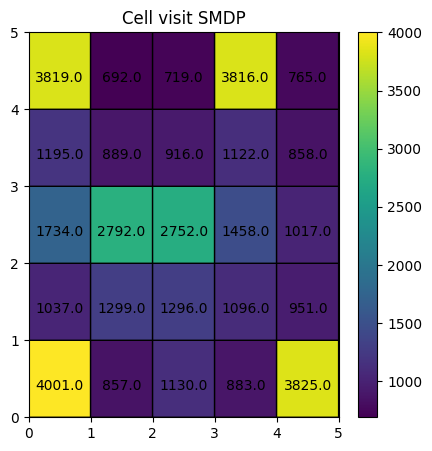

In [40]:
#Reward Curves
plt.figure(figsize=(10,5))
plt.xlabel('Episode')
plt.ylabel('steps')
plt.plot([i for i in range(len(steps_ep_smdp))],steps_ep_smdp )
plt.title("steps vs episode curve for SMDP")
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot([i for i in range(len(rewards_smdp))],rewards_smdp )
plt.title("reward vs episode curve for SMDP")
plt.show()



#Policy
'''
q_values=q_values_SMDP
policy_main = np.argmax(q_values, axis=1).reshape((25, 20))

# Define actions
actions = ['↓', '↑', '←', '→', 'pickup', 'dropoff','A',"B",",C","D"]

# Create a list of colors for each action
colors = ['pink', 'cyan', 'green', 'red', 'yellow', 'purple','green', 'red', 'yellow']

# Create a heat map
for k in range(20):
    policy=policy_main.T[k].reshape((5,5))

    fig, ax = plt.subplots(figsize=(10, 10))
    heatmap = ax.pcolor(policy, cmap='coolwarm', edgecolors='k', linewidths=2)

    # Add the action labels to the heat map
    for i, action in enumerate(actions):
        ax.text(i % 20 + 0.5, i // 20 + 0.5, action, ha='center', va='center', fontsize=14)

    # Add a color bar to the heat map
    cbar = plt.colorbar(heatmap, ticks=np.arange(len(actions)) + 0.5)
    cbar.ax.set_yticklabels(actions)

    # Set the title and axis labels
    ax.set_title('Best Policy Heat Map')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

    # Add gridlines to the heat map
    ax.set_xticks(np.arange(policy.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(policy.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # Add action labels to each grid
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):

            ax.text(j + 0.5, i + 0.5, actions[policy[i, j]], ha='center', va='center', color=colors[policy[i, j]], fontsize=10)

    plt.show()

'''
#State Visit
state_visit_SMDP_step=np.zeros((5,5))
for i in range(500):
    x,y,_,_= list(env.decode(i))
    state_visit_SMDP_step[x][y]+=state_visit_SMDP[i]
state_visit_SMDP_steps=np.resize(state_visit_SMDP_step,(5,5))
plot_Qstep(state_visit_SMDP_steps,'Cell visit SMDP')




In [41]:
loc = {0: 'Red',
 1: 'Green',
 2: 'Yellow',
 3: 'Blue',
 4: 'Taxi'}

action_name = {0: 'S',
 1: 'N',
 2: 'E',
 3: 'W',
 4: 'P',
 5: 'D',
 6: 'R',
 7: 'G',
 8: 'Y',
 9: 'B'}


In [42]:
def Qmatrix(q_values, i, j):
    qmatrix = np.zeros((5,5,10))
    for row in range(5):
        for col in range(5):
            qmatrix[row][col][:] = np.copy(q_values_SMDP[env.encode(row,col,i,j)])
    return qmatrix
def vizQ(q_values):
    for i in range(5):
        for j in range(4):
            if i == j:
                continue
                print(f"Passenger at {loc[i]} going to {loc[j]}")
                for row in range(5):
                    for col in range(5):
                        print(action_name[np.argmax(q_values_SMDP[env.encode(row,col,i,j)])],end=" ")
                print()

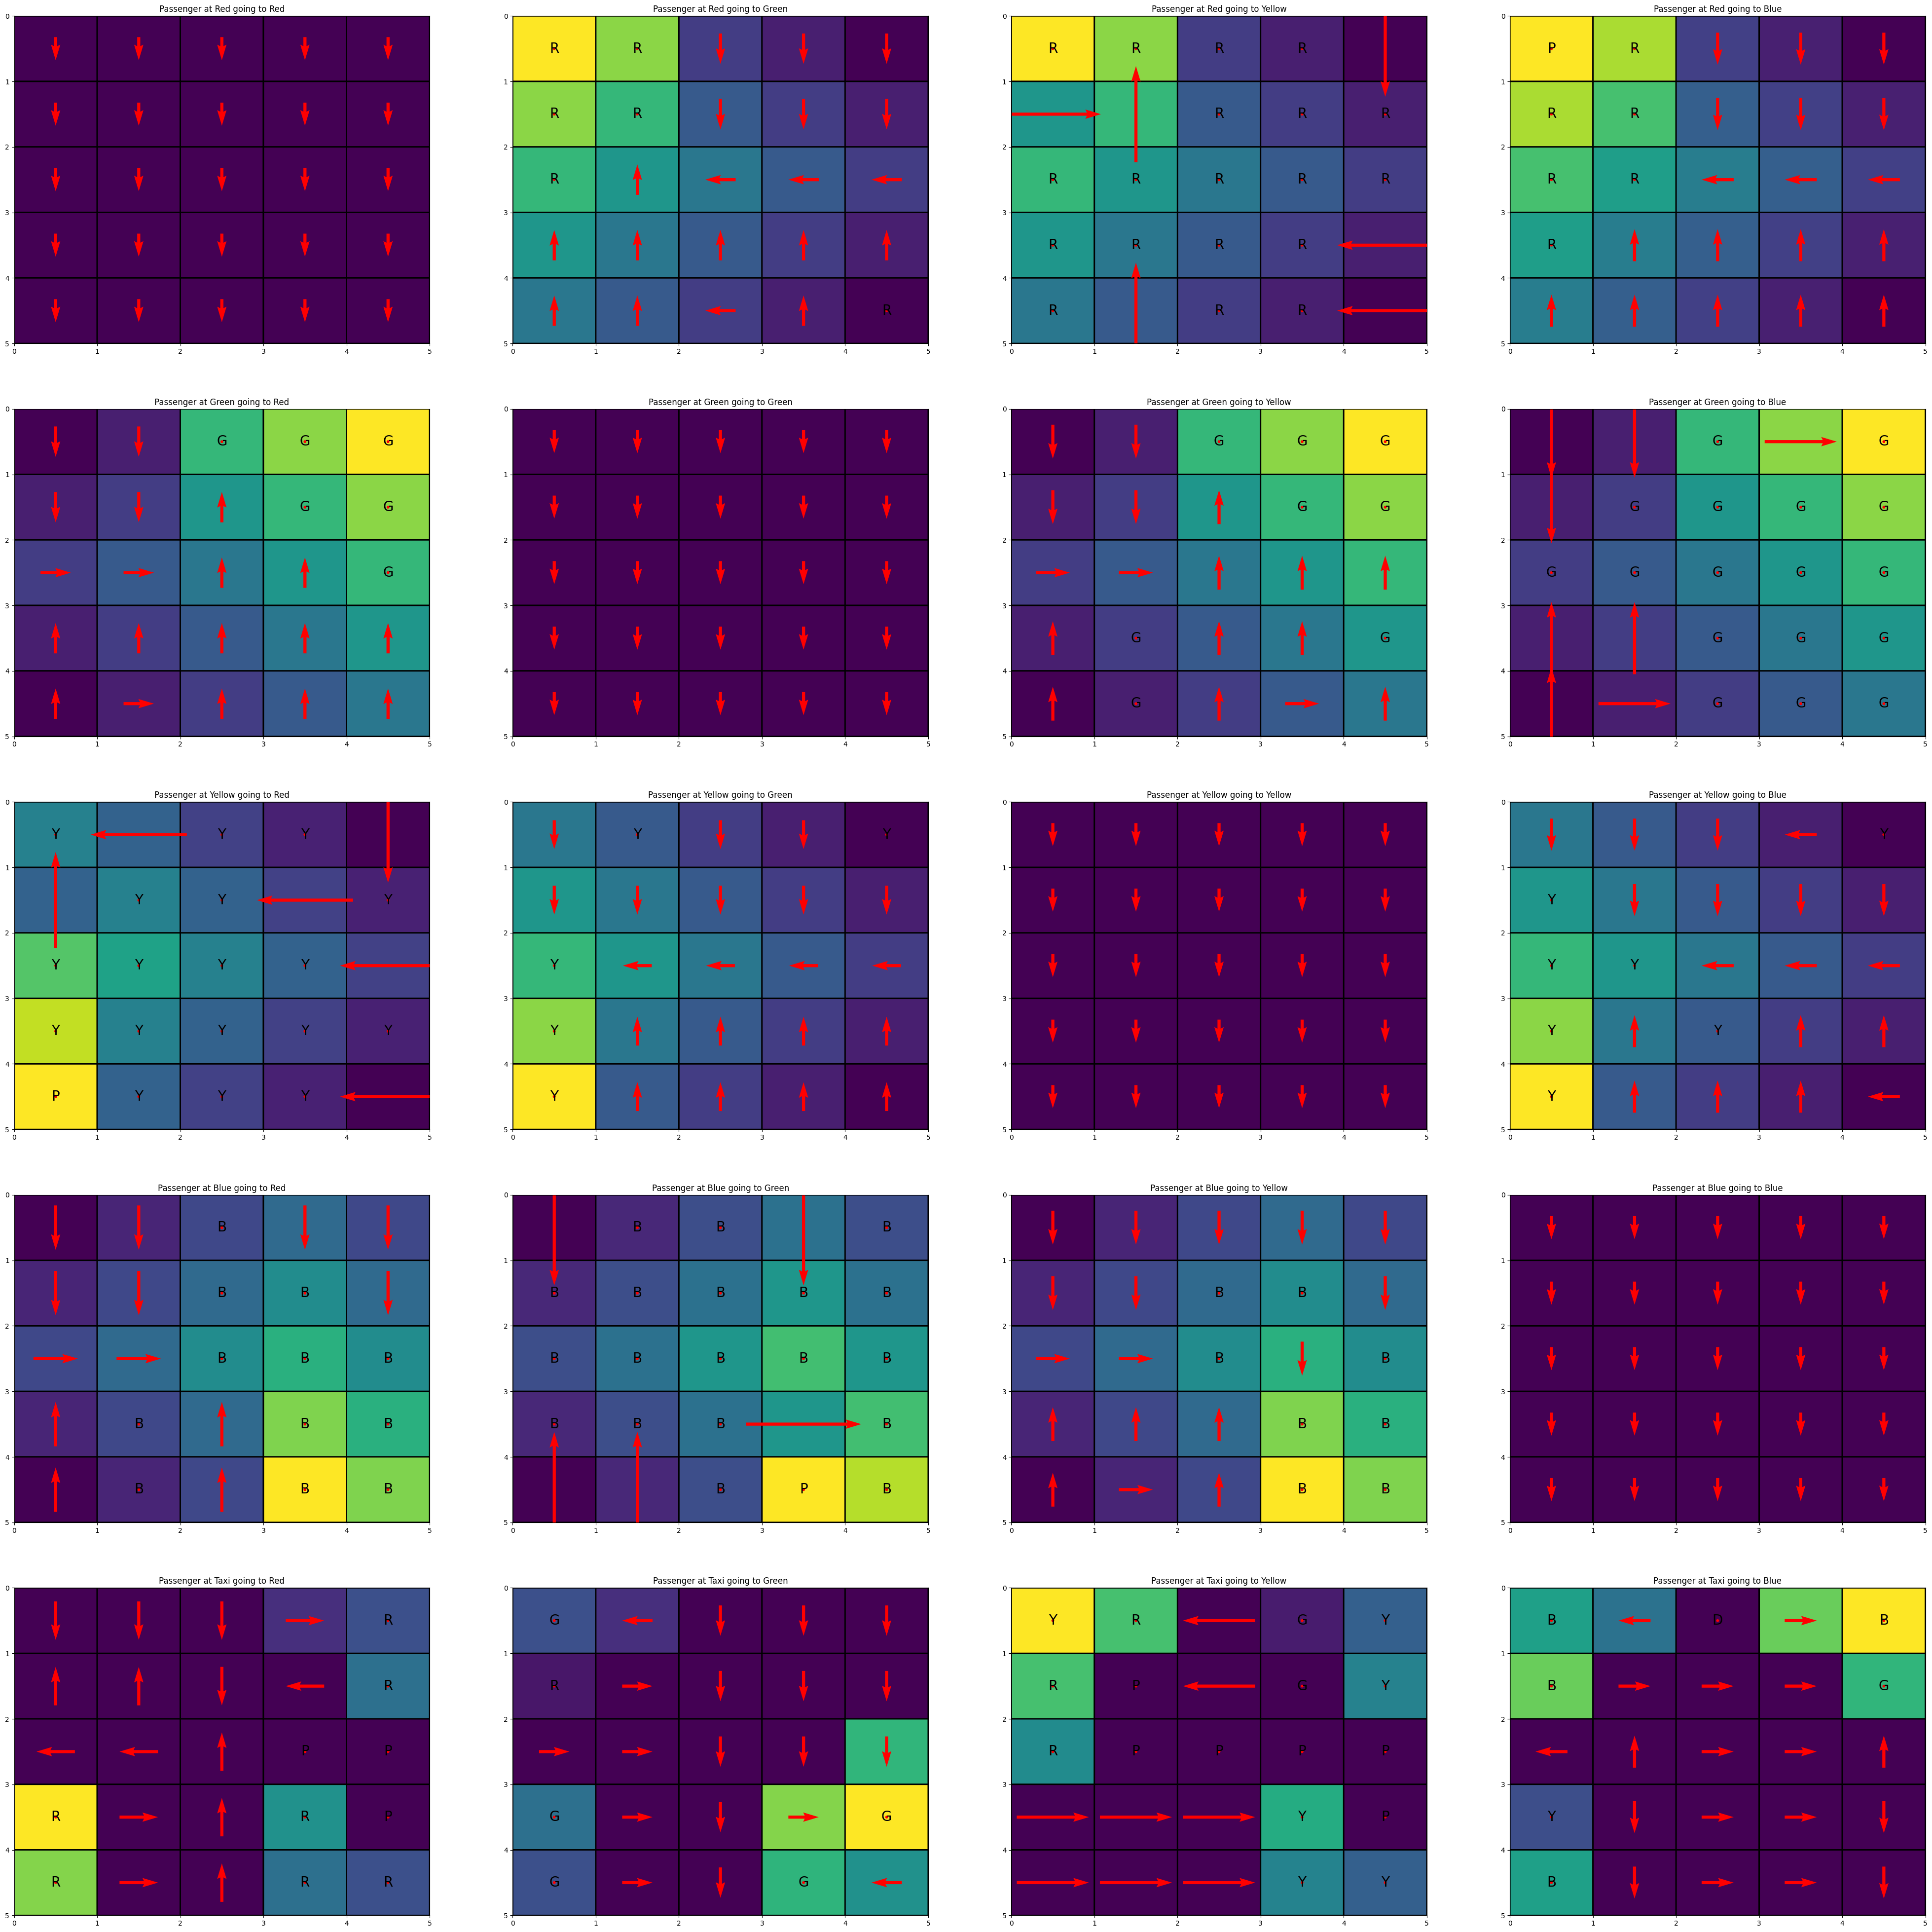

In [43]:
UP = 1
DOWN = 0
LEFT = 3
RIGHT = 2
def plot_Q(q_values):
    fig, axs = plt.subplots(5, 4, figsize=(50,50))
    for i in range(5):
        for j in range(4):
 #if i==j: continue
            Q = Qmatrix(q_values,i,j)
 #fig, ax = plt.subplots()

 # plt.figure(figsize=(5,5))
            axs[i, j].set_title(f"Passenger at {loc[i]} going to {loc[j]}")
            axs[i, j].invert_yaxis()

            axs[i, j].pcolor(Q.max(-1), edgecolors='k', linewidths=2)

            def x_direct(a):
                if a == RIGHT: return 1
                if a == LEFT: return -1
                return 0
            def y_direct(a):
                if a == UP: return 1
                if a == DOWN: return -1
                return 0
            policy = Q.argmax(-1)
            policyx = np.vectorize(x_direct)(policy)
            policyy = np.vectorize(y_direct)(policy)
            idx = np.indices(policy.shape)
            axs[i, j].quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
            for k in range(25):
                act = policy.reshape(25,)[k]
                if act < 4: continue
                axs[i, j].annotate(f'{action_name[act]}', xy=(idx[1].ravel()[k]+0.5,idx[0].ravel()[k]+0.5), fontsize=20, ha='center', va='center')
    plt.show()

pltQ = plot_Q(q_values_SMDP)

INTRA OPTION Q LEARNING

In [58]:
#### Intra-Option Q-Learning

# Add parameters you might need here

q_values_intra = np.zeros((500,10))

#Update_Frequency Data structure? Check TODO 4
freq_2=np.zeros((500,10))
steps_ep_in =[]
rewards_in=[]
avg_steps_ep_in =[]
avg_rewards_in=[]
gamma = 0.9
alpha=0.4
state_visit_intra=np.zeros(500)

# Iterate over 1000 episodes
for eps in range(10000):
    #print("Epi",_,"action")
    state = env.reset()
    done = False
    reward_ep=0
    step_ep=0

    # While episode is not over
    while not done:

        # Choose action
        action = egreedy_policy(q_values_intra, state, epsilon=0.1)

        # Checking if primitive action
        if action <6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, done,info= env.step(action)
            q_values_intra[state][action]=(1-alpha)*(q_values_intra[state][action])+(alpha)*(reward+gamma*(np.max(q_values_intra[next_state])))
            freq_2[state,action]+=1
            state_visit_intra[state]+=1
            state=next_state
            step_ep+=1
            reward_ep+=reward

        # Checking if action chosen is an option

        else: # action => Away,CLose option (Coupled into a single if statement)
            initial_state=np.copy(state)
            optdone = False
            cnt=0

            while (optdone == False):

                # Think about what this function might do?
                optact,optdone,reachedGoal = action_l[action](state)

                next_state, reward, done,info = env.step(optact)
                reward_ep+=reward
                step_ep+=1
                q_values_intra[state, optact] += alpha*(reward + gamma*np.max(q_values_intra[next_state]) - q_values_intra[state, optact])
                freq_2[state,action]+=1
                state_visit_intra[state]+=1

                optact,optdone,reachedGoal = action_l[action](state)

                beta=int(optdone)

                U_s_a=(1-beta)*(q_values_intra[next_state,action]) + beta*(np.max(q_values_intra[next_state]))
                q_values_intra[state,action]=(1-alpha)*(q_values_intra[state,action])+ alpha*(reward+gamma*(U_s_a))
                freq_2[state,action] += 1

                state = next_state

    steps_ep_in.append(step_ep)
    rewards_in.append(reward_ep)

    if(eps%10==0) :
        avg_rewards_in.append(np.mean(rewards_in[-10:]))
        avg_steps_ep_in.append(np.mean(steps_ep_in[-10:]))






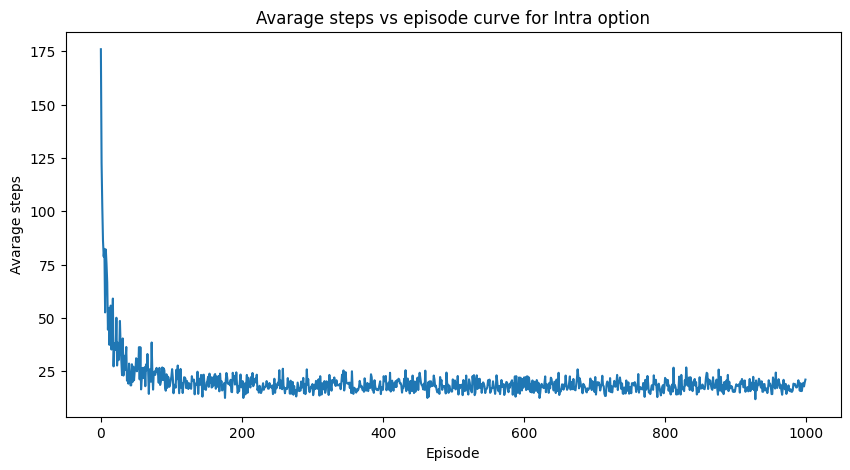

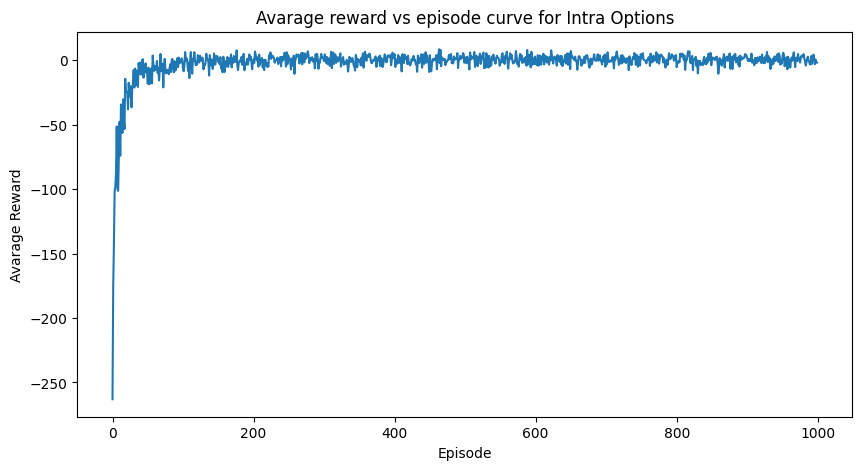

In [59]:

plt.figure(figsize=(10,5))
plt.xlabel('Episode')
plt.ylabel('Avarage steps')
plt.plot([i for i in range(len(avg_steps_ep_in))],avg_steps_ep_in )
plt.title("Avarage steps vs episode curve for Intra option")
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel('Episode')
plt.ylabel('Avarage Reward')
plt.plot([i for i in range(len(avg_rewards_in))],avg_rewards_in )
plt.title("Avarage reward vs episode curve for Intra Options")
plt.show()

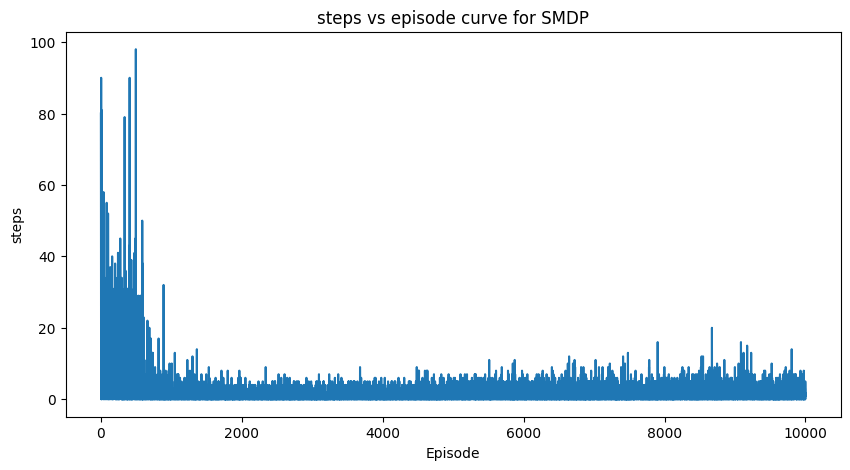

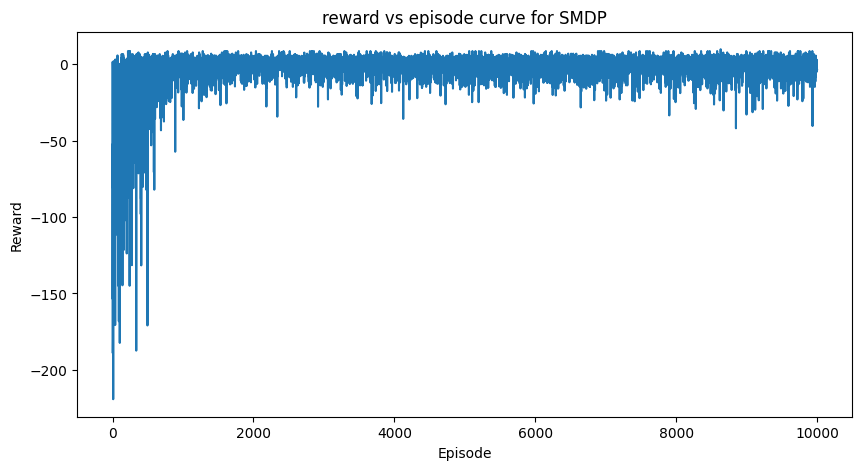

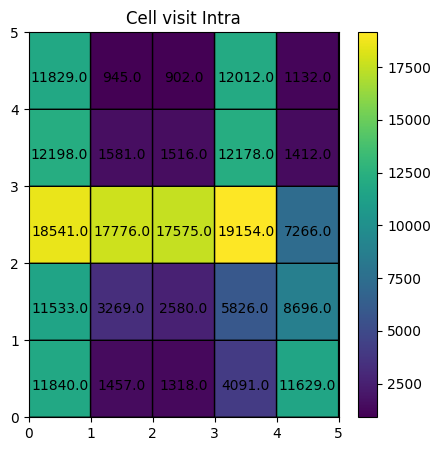

In [60]:
#Reward Curves
plt.figure(figsize=(10,5))
plt.xlabel('Episode')
plt.ylabel('steps')
plt.plot([i for i in range(len(steps_ep_in))],steps_ep_smdp )
plt.title("steps vs episode curve for SMDP")
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot([i for i in range(len(rewards_in))],rewards_smdp )
plt.title("reward vs episode curve for SMDP")
plt.show()


state_visit_intra_step=np.zeros((5,5))
for i in range(500):
    x,y,_,_= list(stateData(i))
    state_visit_intra_step[x][y]+=state_visit_intra[i]
state_visit_intra_steps=np.resize(state_visit_intra_step,(5,5))
plot_Qstep(state_visit_intra_steps,'Cell visit Intra')




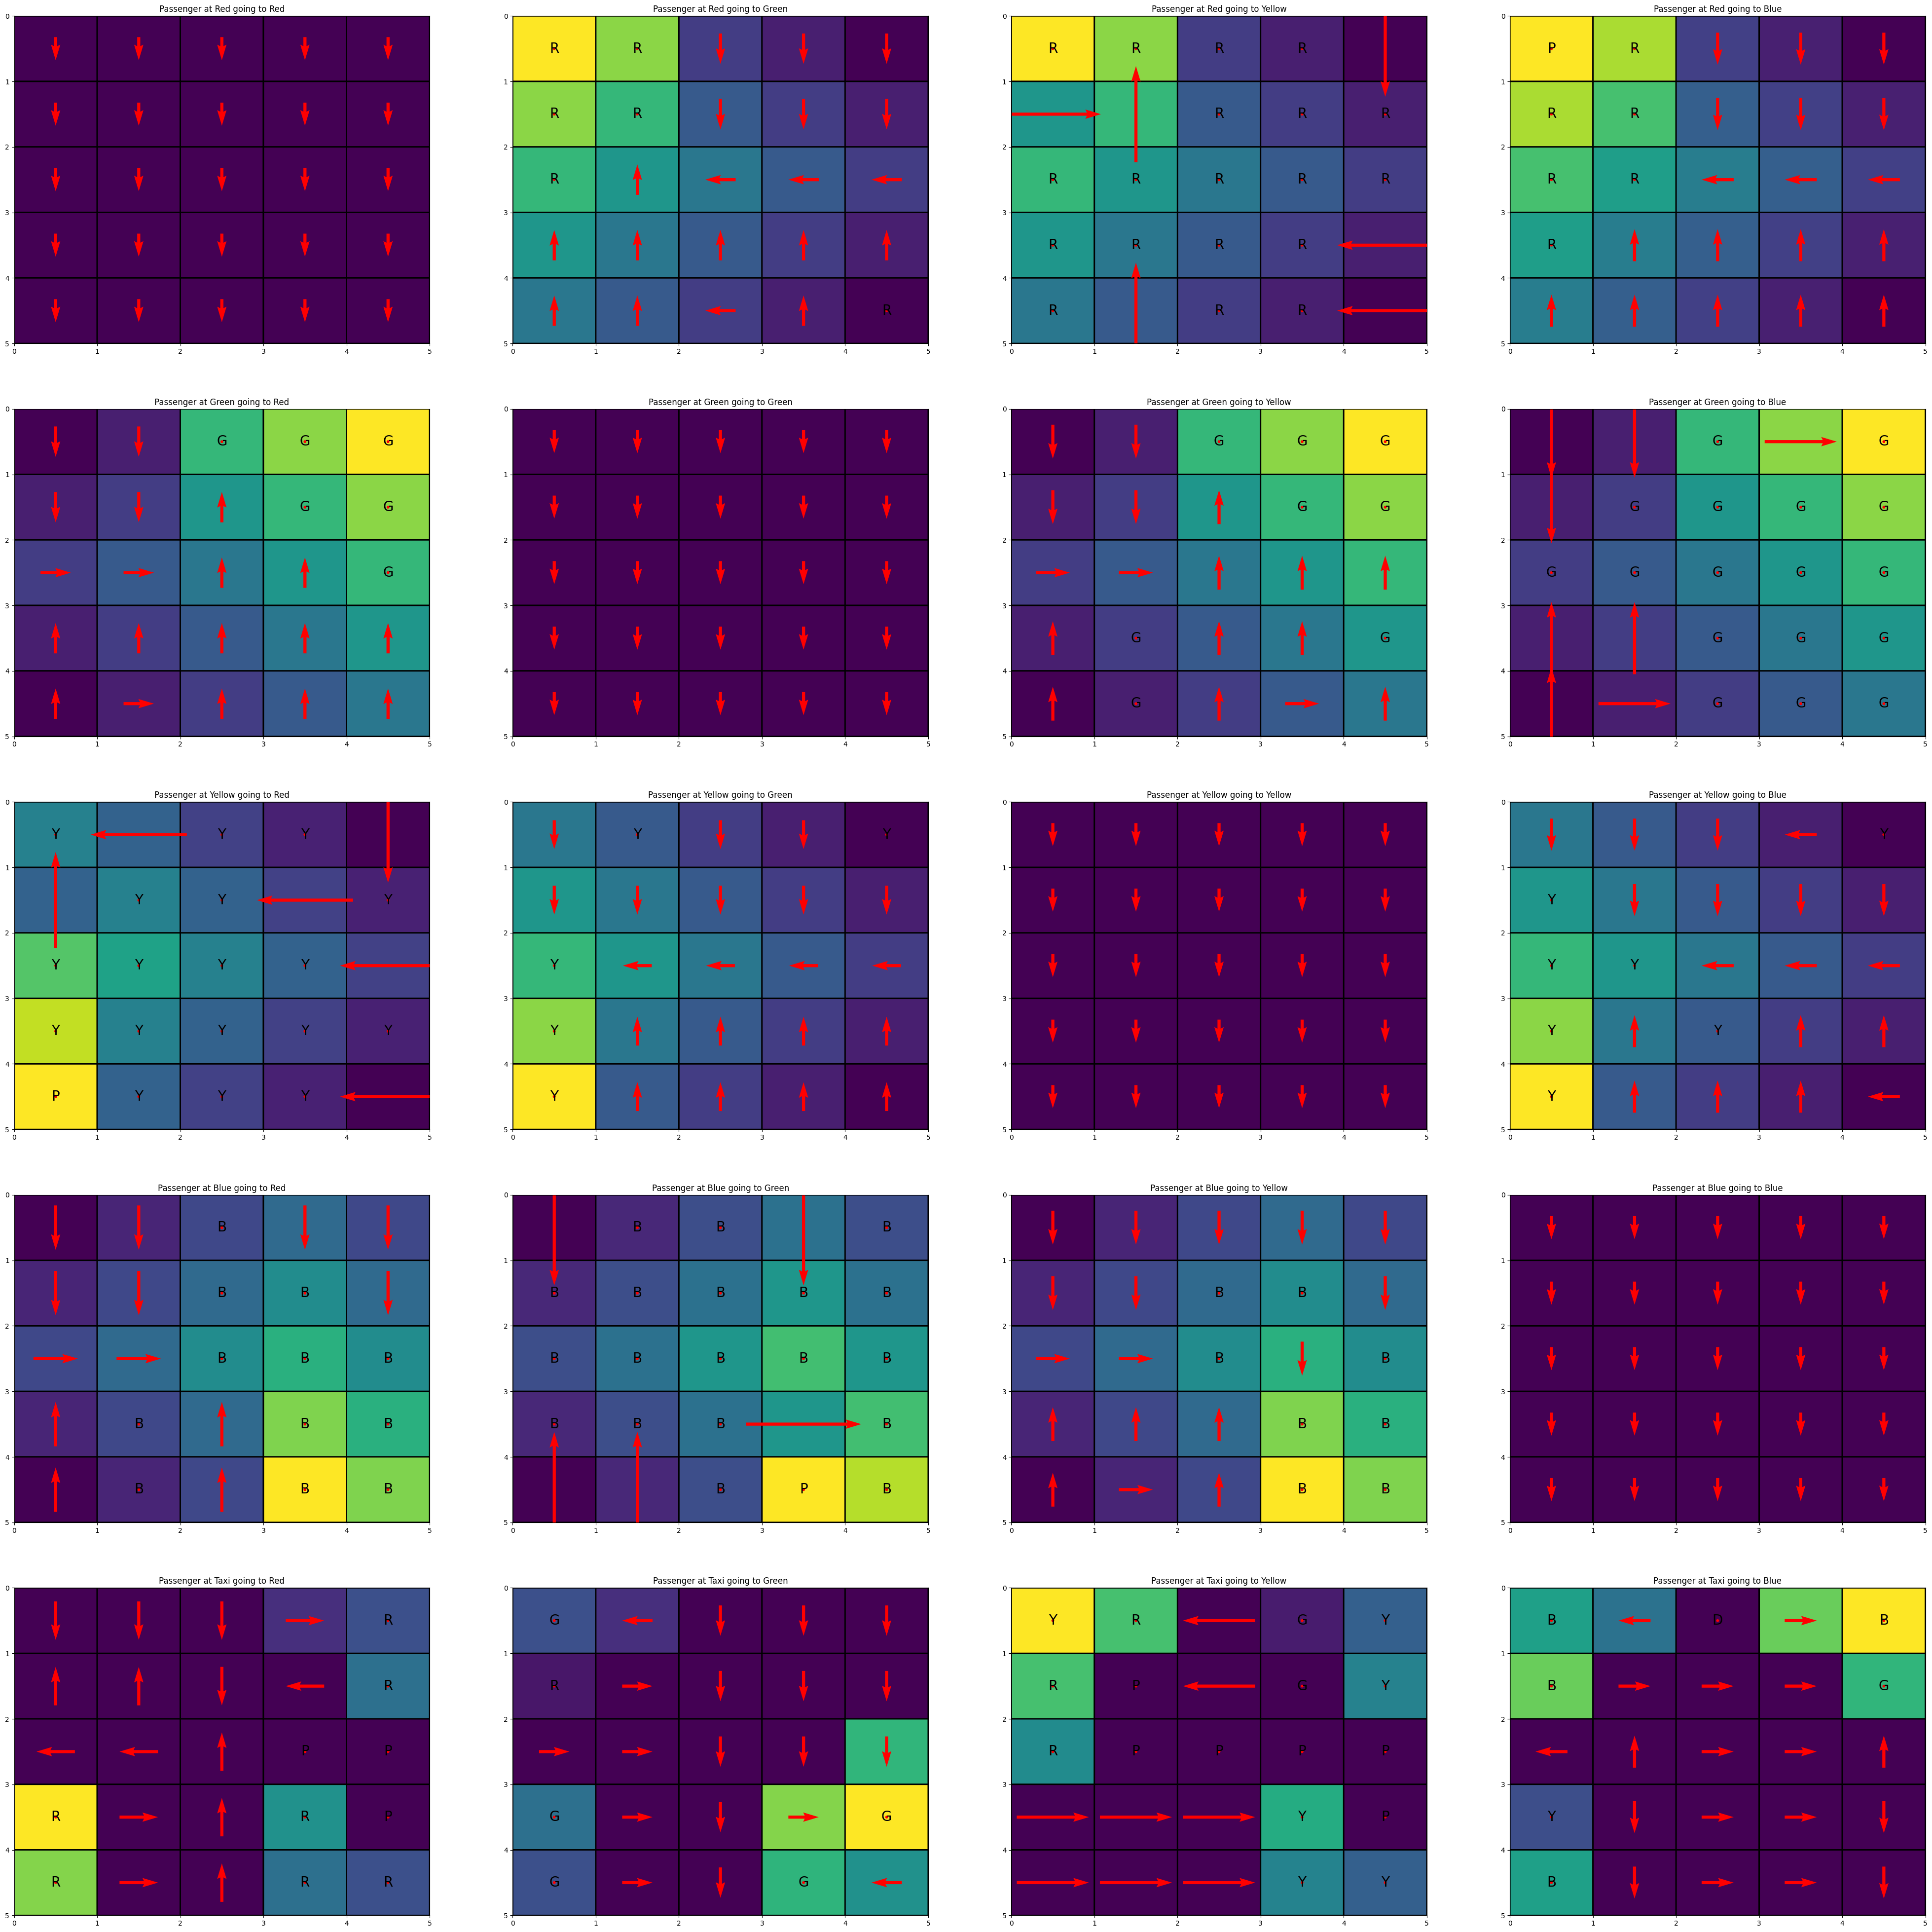

In [61]:
pltQ = plot_Q(q_values_intra)

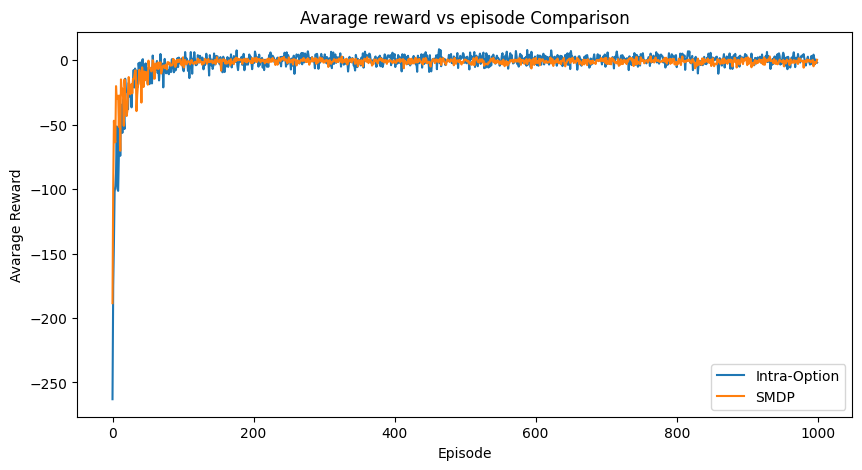

In [64]:
plt.figure(figsize=(10,5))
plt.xlabel('Episode')
plt.ylabel('Avarage Reward')
plt.plot([i for i in range(len(avg_rewards_in))],avg_rewards_in,label="Intra-Option" )
plt.plot([i for i in range(len(avg_rewards_smdp))],avg_rewards_smdp,label="SMDP" )
plt.legend()
plt.title("Avarage reward vs episode Comparison")
plt.show()

In [65]:
print("Average of last 5  values of Average Rewards for Intra Option:",np.mean(avg_rewards_in[-5:]))
print("Average of last 5  values of Average Rewards for SMDP:",np.mean(avg_rewards_smdp[-5:]))

Average of last 5  values of Average Rewards for Intra Option: -0.9199999999999999
Average of last 5  values of Average Rewards for SMDP: -1.519862726399999
